# Segmentation of Road from Satellite imagery

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/MyDrive/eye_in_the_sky"
!ls gdrive/MyDrive/eye_in_the_sky

Mounted at /content/gdrive/
images.h5py  masks.h5py


## Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

## Loading Data

In [28]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3
image_file = base_path + '/images.h5py'
mask_file = base_path + '/masks.h5py'

In [29]:
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('all_images')
images = np.array(n1)
print(images.shape)
hfile.close()

(3822, 256, 256, 3)


In [30]:
hfile = h5py.File(mask_file, 'r')
n1 = hfile.get('all_masks')
masks = np.array(n1)
print(masks.shape)
hfile.close()

(3822, 256, 256)


## Displaying few Samples

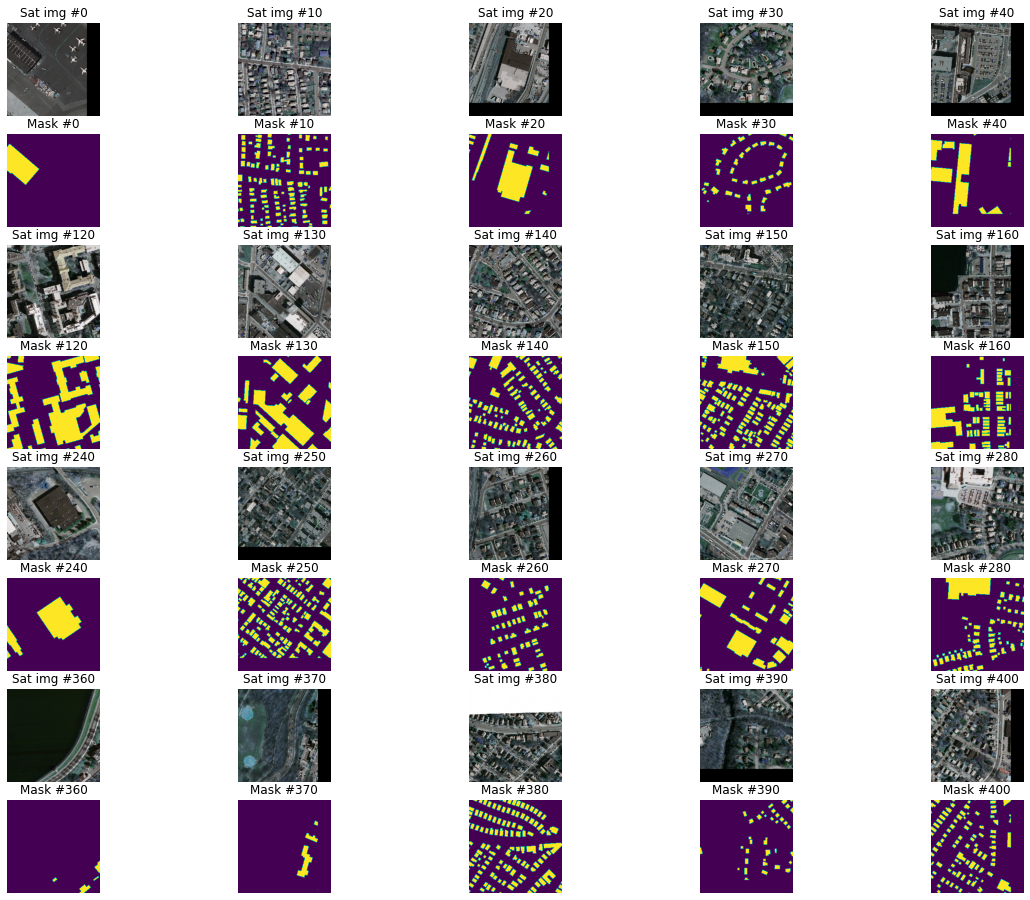

In [31]:
plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(images[pos])
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [7]:
masks = np.expand_dims(masks, -1)

## Defining Custom Loss functions and accuracy Metric.

In [8]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [10]:
def dice_coef(y_true, y_pred, smooth = 1):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

In [11]:
print(masks.shape)
print(images.shape)

(3822, 256, 256, 1)
(3822, 256, 256, 3)


## Splitting data

In [12]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(3057, 256, 256, 3)
(3057, 256, 256, 1)
TEST SET
(765, 256, 256, 3)
(765, 256, 256, 1)


## Defining Our Model

In [13]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

In [14]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### HYPER_PARAMETERS

In [15]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

### Initializing Callbacks

In [16]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

In [16]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://50d26da651fe.ngrok.io


In [17]:
model_path = "./Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

### Compiling the model

In [18]:
opt = keras.optimizers.Adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [19]:
history = model.fit(train_images,
                    train_masks,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer]
                                #  , TensorBoardColabCallback(tbc)]
                       )

Epoch 1/100
172/172 [==============================] - ETA: 0s - loss: 0.5566 - iou_coef: 0.2694WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0075s vs `on_test_batch_end` time: 0.0222s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.90410, saving model to ./Models/road_mapper_2.h5
172/172 [==============================] - 19s 113ms/step - loss: 0.5566 - iou_coef: 0.2694 - val_loss: 0.9041 - val_iou_coef: 0.0554
Epoch 2/100
172/172 [==============================] - ETA: 0s - loss: 0.4344 - iou_coef: 0.3716
Epoch 00002: val_loss improved from 0.90410 to 0.42172, saving model to ./Models/road_mapper_2.h5
172/172 [==============================] - 18s 104ms/step - loss: 0.4344 - iou_coef: 0.3716 - val_loss: 0.4217 - val_iou_coef: 0.3938
Epoch 3/100
172/172 [==============================] - ETA: 0s - loss: 0.3919 - iou_coef: 0.4127
Epoch 00003: val_loss improved from 0.42172 to 0.35023, saving model to ./Mo

In [20]:
model_path = base_path + "building_mapper_final.h5"
model.save(model_path)

## Testing our Model

### On Test Images

In [22]:
model = load_model(model_path, custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [23]:
model.evaluate(test_images, test_masks)

24/24 [==============================] - 2s 71ms/step - loss: 0.2195 - iou_coef: 0.6239


[0.21950964629650116, 0.6239471435546875]

In [24]:
predictions = model.predict(test_images, verbose=1)

24/24 [==============================] - 1s 58ms/step


In [25]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

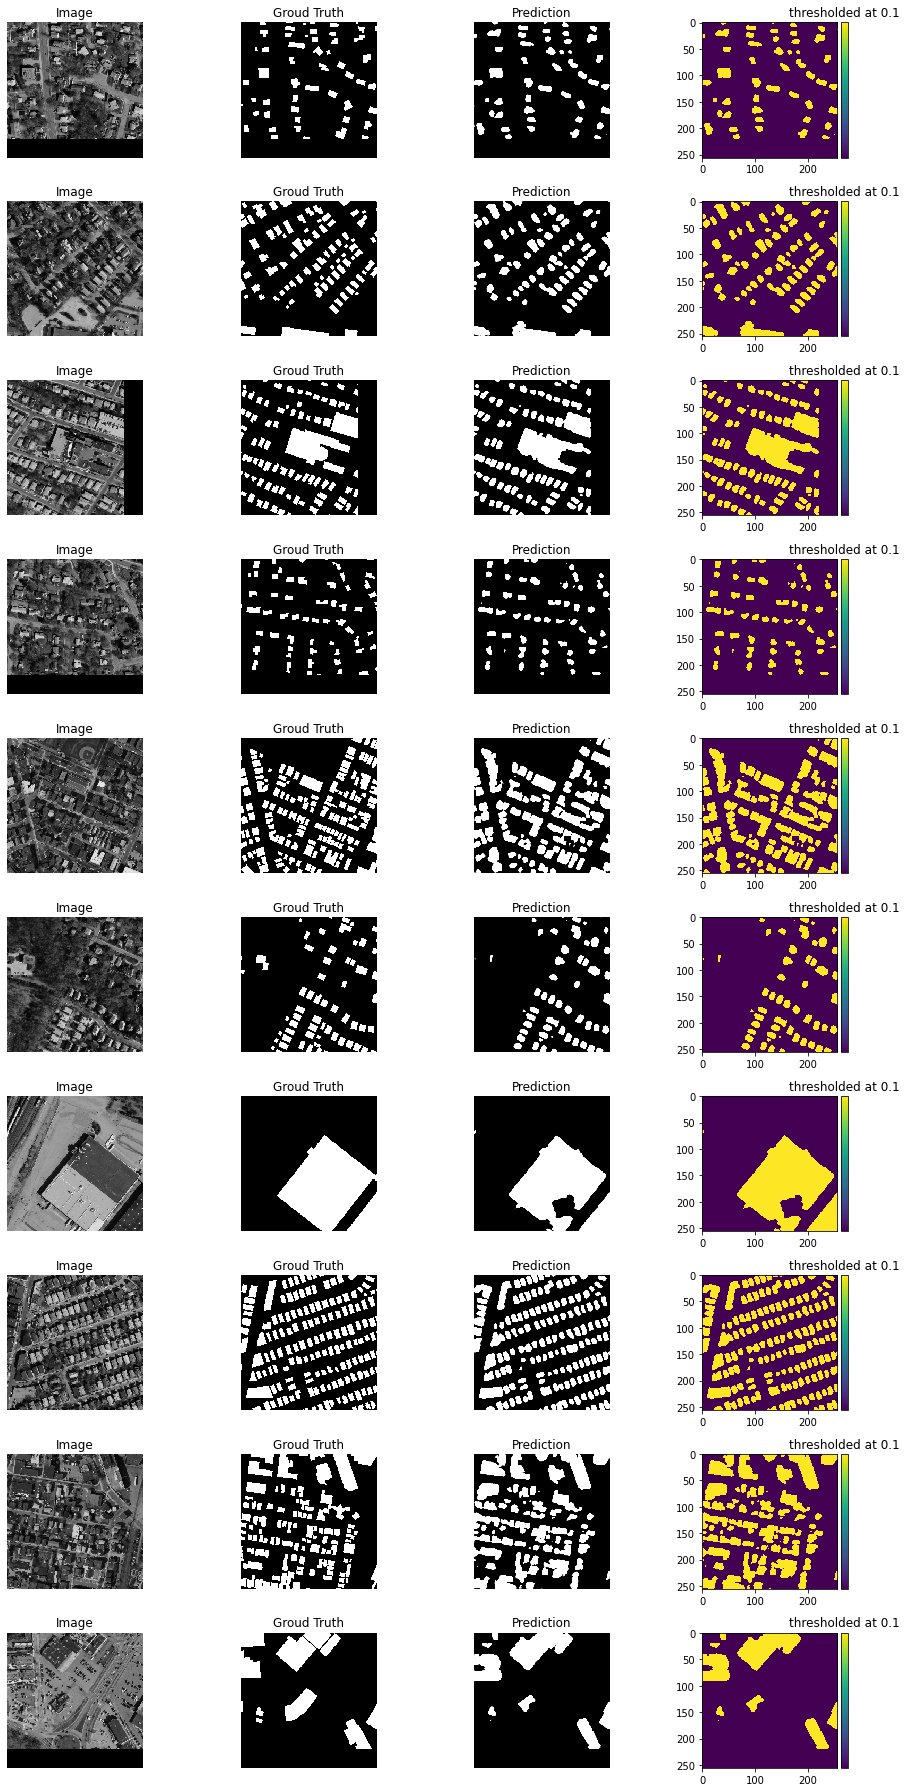

In [26]:
ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()
